# Glauber on infinite random $k$-regular graph
Compute magnetization in the thermodynamic limit $N\to\infty$ for random $k$-regular graphs with $k=8$.

Compare the steady-state magnetization with its equilibrium value.

In [1]:
using MatrixProductBP, MatrixProductBP.Models
using Plots
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2
using LaTeXStrings;

[ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]


In [18]:
T = 25         # final time
k = 8          # degree
m⁰ = 0.3       # magnetization at time zero

β = 1.0
J = 0.2
h = 0.0;

In [19]:
m_eq, = equilibrium_observables(RandomRegular(k), J; β, h)

(m = 0.8596433979493756, r = 0.7570683387764126, e = -0.6056546710211301)

In [76]:
spin(x, i) = 3-2x
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
bp = mpbp_infinite_graph(k, wᵢ, 2, ϕᵢ)
cb = CB_BP(bp);

In [77]:
matrix_sizes = [1, 2, 5, 10, 15]
maxiters = fill(50, length(matrix_sizes))
iters = zeros(Int, length(maxiters))
tol = 1e-4
m = Vector{Vector{Float64}}(undef, length(matrix_sizes))
for i in eachindex(maxiters)
    reset!(bp)
    iters[i], _ = iterate!(bp; maxiter=maxiters[i], svd_trunc=TruncBond(matrix_sizes[i]), cb, tol)
    m[i] = only(means(spin, bp))
end

Running MPBP: iter 134 	 Time: 0:41:16
  Δ:                6.976879986941853e-5
  SVD Matrix size:  15

In [ ]:
push!(matrix_sizes, 25)
reset!(bp)
it, _ = iterate!(bp; maxiter=50, svd_trunc=TruncBond(25), cb, tol)
push!(iters, it)
push!(m, only(means(spin, bp)));

In [ ]:
iters_cum = cumsum(iters)
inds = 1:iters_cum[1]
pl = plot(inds, cb.Δs[inds], label="$(matrix_sizes[1])x$(matrix_sizes[1]) matrices")
for i in 2:length(iters)
    inds = iters_cum[i-1]:iters_cum[i]
   plot!(pl, inds, cb.Δs[inds], label="$(matrix_sizes[i])x$(matrix_sizes[i]) matrices")
end
plot(pl, ylabel="convergence error", xlabel="iters", yaxis=:log10, size=(500,300), legend=:outertopright)

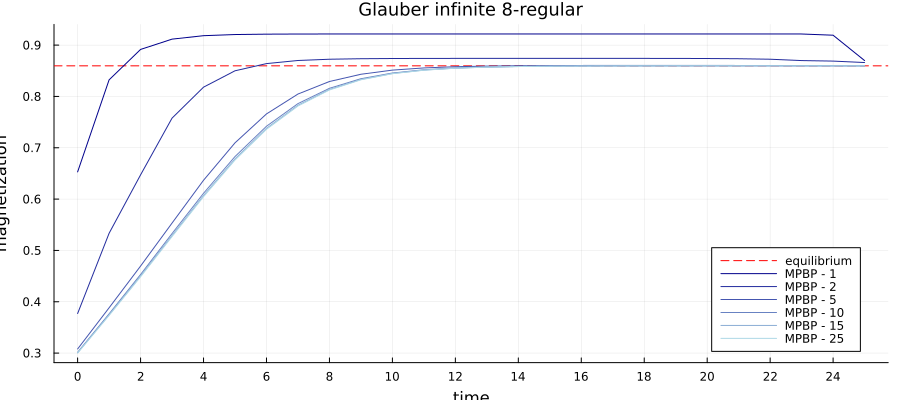

In [94]:
using ColorSchemes

cg = cgrad(:blues, length(matrix_sizes), categorical=true) |> reverse
pl = hline([m_eq], c=:red, ls=:dash, lw=1, label="equilibrium")
for i in eachindex(matrix_sizes)
    plot!(pl, 0:T, m[i], xlabel="time", ylabel="magnetization", label="MPBP - $(matrix_sizes[i])",
        size=(500,300), xticks=0:2:T, ms=3, title="Glauber infinite $k-regular", titlefontsize=12,
        legend=:bottomright, msc=:auto, c=cg[i])
end
plot(pl, size=(900,400))

### Compare with Monte Carlo on finite graphs

In [15]:
using Graphs, IndexedGraphs, Statistics

N = 5*10^3
g = random_regular_graph(N, k)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp_mc = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp_mc);

In [16]:
sample!(sms, 10^3)
spin(x) = 3-2x
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:01:30


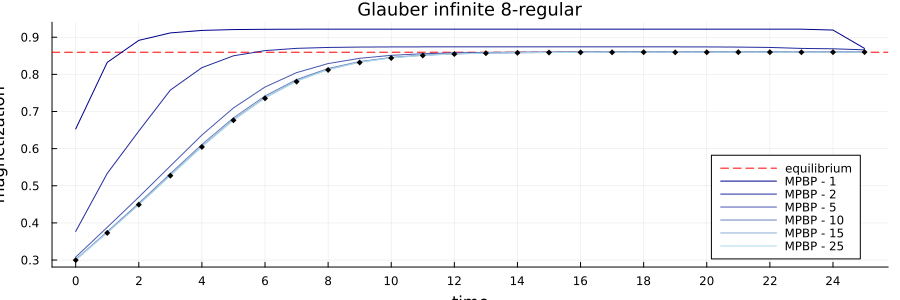

In [95]:
plot!(pl, 0:T, mean(m_mc), c=:black, m=:diamond, ms=3, msc=:auto, label="", st=:scatter, size=(900,300))

In [ ]:
include("../../telegram/notifications.jl");
@telegram "glauber bonddims"

In [96]:
jldsave("plot_data/glauber_infinite8RRG_bonddims.jld2"; T, k, β, J, h, m_mc, m, matrix_sizes);